<a href="https://colab.research.google.com/github/kyle-gao/ML_ipynb/blob/master/TF_CatGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q imageio

In [2]:
import tensorflow as tf
import glob
import imageio
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


In [3]:
 print(tf.__version__)

2.3.0


In [73]:
size = 64
batch_size = 256
noise_dim = 128
preprocesslayers = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(size, size),
  layers.experimental.preprocessing.Rescaling(1./255)
])

In [74]:
def preprocess(ds):
  ds=ds.filter(lambda data: data['label']==0)
  ds=ds.map(lambda data: preprocesslayers(data['image']),num_parallel_calls=tf.data.experimental.AUTOTUNE)
  ds=ds.batch(batch_size)
  ds=ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

In [75]:
train = tfds.load("cats_vs_dogs", split = "train")
ds_train = preprocess(train)

In [76]:
def make_generator():
  model= tf.keras.Sequential([
                              layers.Dense(4*4*512, use_bias=False, input_shape=(noise_dim,)),
                              layers.BatchNormalization(),
                              layers.LeakyReLU(),
                              layers.Reshape((4,4,512)),

                              layers.Conv2DTranspose(256,(5,5),padding="same",use_bias=False),
                              layers.BatchNormalization(),
                              layers.LeakyReLU(),
                              #(8,8,256)

                              layers.Conv2DTranspose(128,(5,5),strides=(2,2),padding="same",use_bias=False),
                              layers.BatchNormalization(),
                              layers.LeakyReLU(),
                              #(16,16,128)

                              layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding="same",use_bias=False),
                              layers.BatchNormalization(),
                              layers.LeakyReLU(),
                              #(32,32,64)

                              layers.Conv2DTranspose(32,(5,5),strides=(2,2),padding="same",use_bias=False),
                              layers.BatchNormalization(),
                              layers.LeakyReLU(),
                              #(64,64,32)

                              layers.Conv2DTranspose(3,(5,5), strides=(2,2),padding="same",use_bias=False,activation='tanh')

  ])
  
  return model

In [77]:
generator=make_generator()
generator.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 8192)              1048576   
_________________________________________________________________
batch_normalization_30 (Batc (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_50 (LeakyReLU)   (None, 8192)              0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_30 (Conv2DT (None, 4, 4, 256)         3276800   
_________________________________________________________________
batch_normalization_31 (Batc (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_51 (LeakyReLU)   (None, 4, 4, 256)       

In [78]:
def make_discriminator():
  model=tf.keras.Sequential([
                             layers.Conv2D(32,(4,4),strides=(2,2),input_shape=(64,64,3),padding='same'),
                             layers.LeakyReLU(),
                             layers.Dropout(0.2),
                             layers.Conv2D(64,(4,4),strides=(2,2),padding='same'),
                             layers.LeakyReLU(),
                             layers.Dropout(0.2),
                             layers.Conv2D(128,(4,4),strides=(2,2),padding='same'),
                             layers.LeakyReLU(),
                             layers.Dropout(0.2),
                             layers.Conv2D(128,(4,4),strides=(2,2),padding='same'),
                             layers.LeakyReLU(),
                             layers.Dropout(0.2),
                             layers.Flatten(),
                             layers.Dense(1)]) #We use from_logits=True
  return model

In [79]:
discriminator = make_discriminator()
discriminator.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 32, 32, 32)        1568      
_________________________________________________________________
leaky_re_lu_55 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 64)        32832     
_________________________________________________________________
leaky_re_lu_56 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 8, 8, 128)       

In [80]:
noise = tf.random.normal([1,noise_dim])
generatedimage=generator(noise,training=False)
decision = discriminator(generatedimage)
print(decision)

tf.Tensor([[-0.00022255]], shape=(1, 1), dtype=float32)


#Loss and optimizers

In [81]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [82]:
def discriminator_loss(real,fake):
  #takes a tuple of batch of discriminator outputs
  real_loss = cross_entropy(tf.ones_like(real),real) #optimum when predicting all reals to be 1.
  fake_loss = cross_entropy(tf.zeros_like(fake),fake) #optimum when predicting all fakes to be 0.
  return real_loss + fake_loss

def generator_loss(fake):
  #takes a batch of discriminator outputs
  return cross_entropy(tf.ones_like(fake),fake) #optimum when predicting all fakes to be 1.

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [83]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [86]:
EPOCHS = 50
num_examples_to_generate = 16


# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

Training loop

In [87]:

@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

In [88]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    gen_loss=0
    disc_loss=0

    for image_batch in dataset:
      gen_loss_step,disc_loss_step=train_step(image_batch)
      gen_loss += gen_loss_step
      disc_loss+= disc_loss_step
    gen_loss = gen_loss/11776
    disc_loss = disc_loss/11776
    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    print (f'Generator loss: {gen_loss} Discriminator loss {disc_loss}')

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [89]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, :])
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

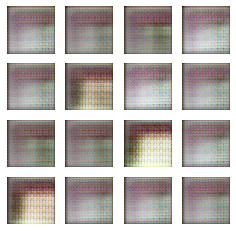

Time for epoch 13 is 18.83062720298767 sec
Generator loss: 0.00424661859869957 Discriminator loss 0.004634803626686335


KeyboardInterrupt: ignored

In [90]:
train(ds_train, EPOCHS)

In [22]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, :])
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
  return predictions

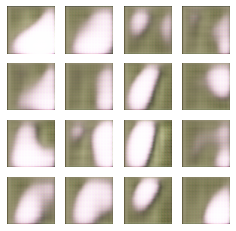

In [25]:
predictions = generate_and_save_images(generator,50,seed)

In [30]:
generator(seed,training=False)

<tf.Tensor: shape=(16, 128, 128, 3), dtype=float32, numpy=
array([[[[0.17073001, 0.11991169, 0.13495465],
         [0.17303148, 0.19565037, 0.135614  ],
         [0.35487586, 0.29304665, 0.29033387],
         ...,
         [0.3741197 , 0.37397647, 0.23884182],
         [0.39431635, 0.3411408 , 0.3306822 ],
         [0.26595756, 0.28238475, 0.09118802]],

        [[0.11588381, 0.20144139, 0.1244649 ],
         [0.331494  , 0.2655746 , 0.26889786],
         [0.3064061 , 0.37093955, 0.39408812],
         ...,
         [0.40039518, 0.5804877 , 0.49086508],
         [0.41038904, 0.4362712 , 0.41928363],
         [0.3075339 , 0.31887886, 0.42409724]],

        [[0.36180085, 0.23900118, 0.16314805],
         [0.26044983, 0.3964809 , 0.16057158],
         [0.62050617, 0.52458113, 0.39599794],
         ...,
         [0.6083027 , 0.58851075, 0.3607704 ],
         [0.6665323 , 0.5575247 , 0.47453123],
         [0.45753953, 0.47218543, 0.1532287 ]],

        ...,

        [[0.28135616, 0.36996958,

In [58]:
46*256

11776